# Random NN modes

### useful tools

In [1]:
%run tools.ipynb

### fully randomized model

In [2]:
from math import ceil
from random import uniform

from xenonpy.model.nn import Generator1d
from xenonpy.model.nn import wrap

g = Generator1d(290, 1,
                n_neuron=[ceil(uniform(0.8, 1.2) * 290) for n in range(5)],
                layer_func=(wrap.L1.conv(kernel_size=3),),
                batch_normalize=(wrap.L1.batch_norm(),)
               )

models = g(5, n_models=10, replace=False)  # return generator
model = next(models)
model

Sequential(
  (0): Layer1d(
    (layer): Conv1d(290, 325, kernel_size=(3,), stride=(1,))
    (batch_nor): BatchNorm1d(325, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (1): Layer1d(
    (layer): Conv1d(325, 332, kernel_size=(3,), stride=(1,))
    (batch_nor): BatchNorm1d(332, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (2): Layer1d(
    (layer): Conv1d(332, 332, kernel_size=(3,), stride=(1,))
    (batch_nor): BatchNorm1d(332, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (3): Layer1d(
    (layer): Conv1d(332, 302, kernel_size=(3,), stride=(1,))
    (batch_nor): BatchNorm1d(302, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (4): Layer1d(
    (layer): Conv1d(302, 302, kernel_size=(3,), stride=(1,))
    (batch_nor): BatchNorm1d(302, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

### scheduled random model

1. Create first layer with random parameters
2. Next layer's parameters dependent on the previous one

In [3]:
from math import ceil
from random import uniform
from torch.nn import ReLU

g = Generator1d(290, 1,
                n_neuron=[ceil(uniform(0.8, 1.2) * 290) for n in range(5)],
                act_func=(ReLU(),),
                drop_out=(0.1,),
                batch_normalize=(wrap.L1.batch_norm(), wrap.L1.batch_norm(momentum=0.2))
               )
N_MAX = 20
def scheduler(i, paras):
    print('layer %s' % i)
    n_out = max(ceil(paras['n_out'] * uniform(0.5, 0.8)), N_MAX)
    return dict(paras, n_out=n_out)

models = g(5, n_models=10,
       replace=True,
       scheduler=scheduler
       )
model = next(models)
model
# len(list(m))

layer 1
layer 2
layer 3
layer 4


Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=248, bias=True)
    (batch_nor): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=248, out_features=177, bias=True)
    (batch_nor): BatchNorm1d(177, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=177, out_features=139, bias=True)
    (batch_nor): BatchNorm1d(139, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=139, out_features=77, bias=True)
    (batch_nor): BatchNorm1d(77, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Layer1d(
    (layer): Linear(in_fea

### modle training

Use `xenonpy.model.nn.RegressionRunner` to train model.

In [4]:
# --- import necessary libraries

from xenonpy.datatools import Splitter, preset
from xenonpy.descriptor import Compositions

In [5]:
samples = preset.mp_samples
samples.head(3)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,pretty_formula,structure,volume
mp-1008807,0.0000,"{'Rb': 1.0, 'Cu': 1.0, 'O': 1.0}",4.784634,0.996372,1.100617,"[Cu, O, Rb]",-3.302762,-0.186408,RbCuO,"[[-3.05935361 -3.05935361 -3.05935361] Rb, [0....",57.268924
mp-1009640,0.0000,"{'Pr': 1.0, 'N': 1.0}",8.145777,0.759393,5.213442,"[N, Pr]",-7.082624,-0.714336,PrN,"[[0. 0. 0.] Pr, [1.57925232 1.57925232 1.58276...",31.579717
mp-1016825,0.7745,"{'Hf': 1.0, 'Mg': 1.0, 'O': 3.0}",6.165888,0.589550,2.424570,"[Hf, Mg, O]",-7.911723,-3.060060,HfMgO3,"[[2.03622802 2.03622802 2.03622802] Hf, [0. 0....",67.541269


In [6]:
comps_desc = Compositions().transform(samples)
form_en = samples['final_energy_per_atom']

In [7]:
# --- split train and test data

splitter = Splitter(len(form_en), test_size=0.2)
X_train, X_test, y_train, y_test = splitter.split(comps_desc.values, form_en.values.reshape(-1, 1))

In [8]:
# check data

print('shape of X_train:', X_train.shape)
print('shape of y_train:', y_train.shape)
print('shape of X_test:', X_test.shape)
print('shape of y_test:', y_test.shape)

shape of X_train: (746, 290)
shape of y_train: (746, 1)
shape of X_test: (187, 290)
shape of y_test: (187, 1)


In [9]:
# --- import necessary libraries

from xenonpy.model.nn import RegressionRunner

In [10]:
# train model with runner and save outputs
with RegressionRunner(epochs=400,  # num of iter
                      log_step=40,  # num of interval for log
                      check_step=40,  # num of interval for checkpoint
                      cuda=False,  # Whether to use cuda
                      work_dir='./'  # destination for model saving
                     ) as runner:
    runner(model, name='formation_energy', lr=0.005)
    
    dataloader = runner.batch_tensor((X_train, None), (y_train, None), batch_size=50)  # minimum batch size
    runner.fit(data_loader=dataloader)  # train
    y_fit_true, y_fit_pred = runner.predict(X_train, y_train)  # predict
    y_true, y_pred = runner.predict(X_test, y_test)
    
    scores = metrics(y_true, y_pred)
    
    print('test performance >> MAE: %f, Corr: %f' % (scores['mae'], scores['pearsonr']))
    
    # additional savings
    runner.persist(splitter=splitter, scores=scores, y_true=y_true, y_pred=y_pred, y_fit_true=y_fit_true, y_fit_pred=y_fit_true)

|> Runner environment:
|> Running dir: ./
|> Epochs: 400
|> Context: cpu
|> Check step: 40
|> Log step: 40

|> start runner <RegressionRunner> at 2019/03/30 18:03:42
|> training model: <formation_energy>
|> start: 2019/03/30 18:03:42
|> 
|> 0/400, Loss=36.2531, elapsed time: 0:00:00.105974
|> 40/400, Loss=1.3403, elapsed time: 0:00:06.186572
|> 80/400, Loss=2.1837, elapsed time: 0:00:06.586105
|> 120/400, Loss=0.4195, elapsed time: 0:00:06.901074
|> 160/400, Loss=0.6255, elapsed time: 0:00:06.881551
|> 200/400, Loss=0.6215, elapsed time: 0:00:06.876165
|> 240/400, Loss=1.0451, elapsed time: 0:00:07.104183
|> 280/400, Loss=1.0208, elapsed time: 0:00:07.099687
|> 320/400, Loss=0.3019, elapsed time: 0:00:07.033986
|> 360/400, Loss=0.3327, elapsed time: 0:00:07.096602
|> Final loss=0.2999
|> 
|> done: 2019/03/30 18:04:51
|> elapsed time: 0:01:09.000467



(array([[-3.870708 ],
        [-7.779522 ],
        [-3.3216949],
        [-5.656467 ],
        [-1.8144342],
        [-6.602935 ],
        [-8.208861 ],
        [-5.053064 ],
        [-4.7519016],
        [-5.5428123],
        [-5.807635 ],
        [-7.282968 ],
        [-3.8849316],
        [-9.444087 ],
        [-3.740812 ],
        [-6.5263386],
        [-3.962737 ],
        [-6.374157 ],
        [-6.851529 ],
        [-7.2711425],
        [-4.352741 ],
        [-3.3370087],
        [-8.941828 ],
        [-6.8095803],
        [-9.812185 ],
        [-6.705984 ],
        [-6.299413 ],
        [-4.6432333],
        [-6.7313213],
        [-3.5945237],
        [-6.1943173],
        [-3.6218014],
        [-3.2441816],
        [-6.834763 ],
        [-6.521065 ],
        [-4.91765  ],
        [-5.4643373],
        [-5.7319894],
        [-5.0227885],
        [-7.2292495],
        [-8.974676 ],
        [-5.472969 ],
        [-6.7899313],
        [-7.894846 ],
        [-6.918079 ],
        [-

test performance >> MAE: 0.553666, Corr: 0.841142
|> done runner <RegressionRunner>: 2019/03/30 18:04:51
|> total elapsed time: 0:01:09.060461


Missing directory and/or file name information!


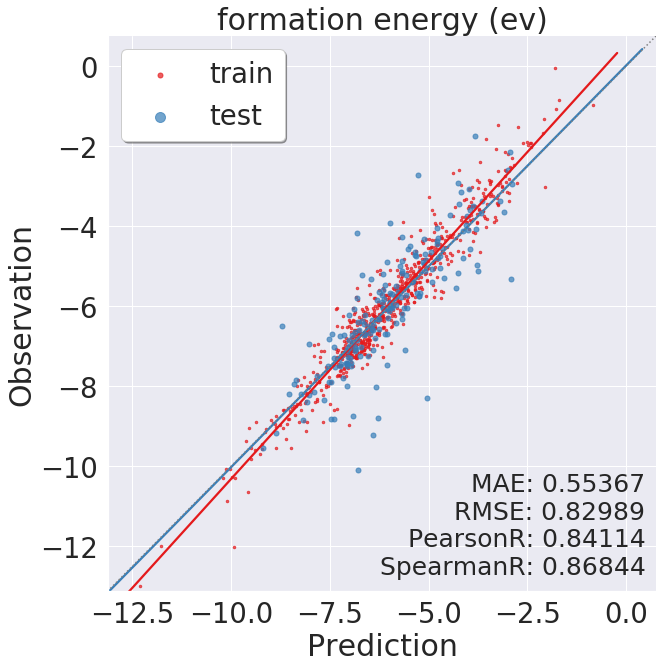

In [11]:
draw(y_true, y_pred, y_fit_true, y_fit_pred, prop_name='formation energy (ev)')